In [1]:
import shap
import torch
from torch import nn
import json
from torchmetrics import R2Score

In [2]:
inputSize = 573
net = nn.Sequential(nn.Linear(inputSize, 8192),
                    nn.LeakyReLU(),
                    nn.Linear(8192, 4096),
                    nn.LeakyReLU(),
                    nn.Linear(4096, 2048),
                    nn.LeakyReLU(),
                    nn.Linear(2048, 1024),
                    nn.LeakyReLU(),
                    nn.Linear(1024, 512),
                    nn.LeakyReLU(),
                    nn.Linear(512, 256),
                    nn.LeakyReLU(),
                    nn.Linear(256, 128),
                    nn.LeakyReLU(),
                    nn.Linear(128, 64),
                    nn.LeakyReLU(),
                    nn.Linear(64,32),
                    nn.LeakyReLU(),
                    nn.Linear(32,1))

In [3]:
net.load_state_dict(torch.load("../trained_models/1680367867-4096-573-AllFields.pt"))

<All keys matched successfully>

In [4]:
testSetX = torch.load("../dataset/testSetX.pt")
testSetY = torch.load("../dataset/testSetY.pt")
# testSetX = testSetX.to(device)
# testSetY = testSetY.to(device)
print(testSetX.shape)
print(testSetY.shape)

torch.Size([217324, 573])
torch.Size([217324])


In [5]:
with open ("../dataset/columns.json", "r") as f:
	columns = json.load(f)

In [6]:

net = net.eval()

with torch.no_grad():
	pred = net(testSetX)
	print(pred.shape)


torch.Size([217324, 1])


In [13]:
print(pred.shape)
print(testSetY.shape)
r2score = R2Score()
r2score(pred, testSetY)
r2score = r2score.compute()
print(r2score)

torch.Size([217324])
torch.Size([217324])
tensor(0.4414)


In [14]:
# Use the DeepExplainer to explain the model
torch.set_grad_enabled(True)
background = testSetX[:100]
e = shap.DeepExplainer(net, background)
shape_values = e.shap_values(testSetX[0:10])


Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


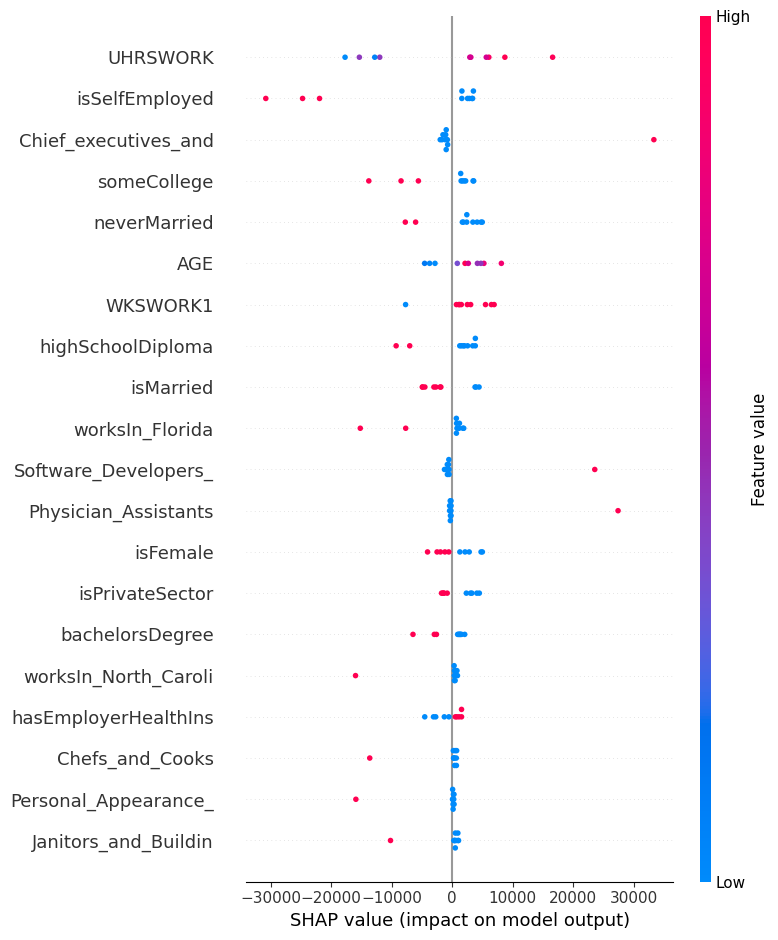

In [15]:
for i in range(0, len(columns)):
    if columns[i].find("occupation_") != -1:
        columns[i] = columns[i][11:]
    columns[i] = columns[i][:20]

shap.summary_plot(shape_values, testSetX[0:10], feature_names=columns)